In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
df = pd.read_csv("Employee-Attrition.csv")

# Basic info
print("Shape of the dataset:", df.shape)
df.head()


Shape of the dataset: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

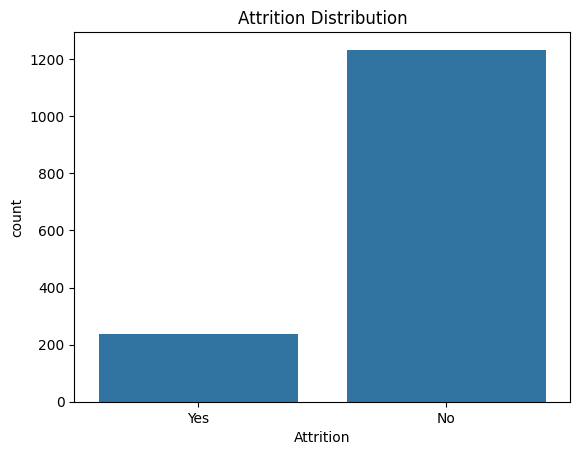

Categorical columns:
 Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')
Attrition: 2 unique values
BusinessTravel: 3 unique values
Department: 3 unique values
EducationField: 6 unique values
Gender: 2 unique values
JobRole: 9 unique values
MaritalStatus: 3 unique values
Over18: 1 unique values
OverTime: 2 unique values


In [2]:
# Step 2: Basic Data Exploration
df.info()  # Check for nulls and data types
print("\nMissing values per column:\n", df.isnull().sum())

# Target variable distribution
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

# Unique values in categorical features
cat_cols = df.select_dtypes(include='object').columns
print("Categorical columns:\n", cat_cols)
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")


In [3]:
# Step 3: Data Preprocessing

# Drop irrelevant columns (like EmployeeNumber, Over18, etc.)
df = df.drop(['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1)

# Encode the target column (Attrition: Yes/No → 1/0)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Encode categorical features
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])

# Feature-target split
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
    

Training set shape: (1176, 30)
Test set shape: (294, 30)


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.46      0.13      0.20        47

    accuracy                           0.84       294
   macro avg       0.66      0.55      0.55       294
weighted avg       0.79      0.84      0.80       294

Accuracy Score: 0.8367346938775511


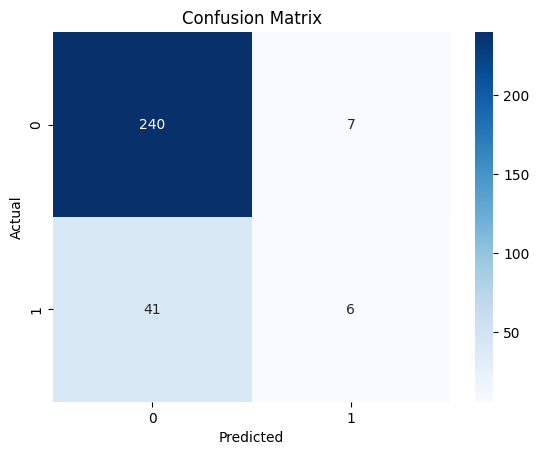

In [4]:
# Step 4: Train a baseline model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Step 5: Explainability with SHAP
import shap

# Create the SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_train, feature_names=X.columns)

# Optional: force plot for a single prediction
# Pick one test instance (e.g., index 5)
sample_idx = 5
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_idx], X.iloc[sample_idx])


In [5]:
!pip install shap

In [8]:
import shap

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_train, feature_names=X.columns)

# Optional: force plot for a single prediction
# Pick one test instance (e.g., index 5)
sample_idx = 5
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_idx], X.iloc[sample_idx])

In [11]:
import shap

# Create a DataFrame from the scaled training data with proper column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# SHAP Explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_df)

# Summary Plot
shap.summary_plot(shap_values[1], X_train_df)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap

# Ensure X_train_df is correctly formed
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Initialize SHAP TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_df)

# Use class 1 SHAP values (Attrition = Yes)
shap.summary_plot(shap_values[1], features=X_train_df, feature_names=X.columns)


In [ ]:
# Step 5: SHAP from scratch using unscaled data

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Use original unscaled DataFrame
X_unscaled = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split on unscaled data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X_unscaled, y, test_size=0.2, random_state=42, stratify=y)

# Retrain model on unscaled data
rf_unscaled = RandomForestClassifier(random_state=42)
rf_unscaled.fit(X_train_unscaled, y_train)

# SHAP Explainer
explainer = shap.TreeExplainer(rf_unscaled)
shap_values = explainer.shap_values(X_train_unscaled)

# SHAP Summary Plot
shap.summary_plot(shap_values[1], X_train_unscaled, feature_names=X_unscaled.columns)


In [ ]:
import shap
import numpy as np

# Train-test split (on unscaled features)
X_unscaled = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X_unscaled, y, test_size=0.2, random_state=42, stratify=y)

# Retrain model
rf_unscaled = RandomForestClassifier(random_state=42)
rf_unscaled.fit(X_train_unscaled, y_train)

# SHAP explainer
explainer = shap.TreeExplainer(rf_unscaled)
shap_values = explainer.shap_values(X_train_unscaled)

# 🚨 Check how many classes we have in SHAP output
print(f"Number of SHAP outputs: {len(shap_values)}")
print(f"SHAP shape: {np.shape(shap_values)}")

# ✅ Use the correct class index automatically
class_index = 1 if len(shap_values) > 1 else 0

# SHAP Summary Plot
shap.summary_plot(shap_values[class_index], X_train_unscaled, feature_names=X_unscaled.columns)


In [12]:
import shap

# Ensure that shap_values has the correct shape (1176, 30, 2)
print(shap_values.shape)  # Should be (1176, 30, 2)

# Ensure that X_train_unscaled has the correct shape (1176, 30)
print(X_train_unscaled.shape)  # Should be (1176, 30)

# Select the SHAP values for the "Yes" class (attrition)
class_index = 1  # Choose 1 for attrition "Yes" or 0 for "No"
shap_values_class = shap_values[:, :, class_index]

# Verify the feature names
print(X_unscaled.columns)

# Make sure the feature names match the SHAP values
assert X_train_unscaled.shape[1] == shap_values_class.shape[1], "Feature mismatch between SHAP values and input data"

# Plot the SHAP summary for the class "Yes" (attrition)
shap.summary_plot(shap_values_class, X_train_unscaled, feature_names=X_unscaled.columns)


(1176, 30, 2)


NameError: name 'X_train_unscaled' is not defined

In [ ]:
# Make a single prediction
sample_data = X_train_unscaled.iloc[0]  # For example, the first row in the training set
prediction = model.predict([sample_data])
print(f"Prediction for sample: {prediction}")


In [ ]:
import joblib

# Load the pre-trained model (make sure to replace 'your_model.pkl' with the correct file path)
model = joblib.load('your_model.pkl')


In [ ]:
import shap

# Pick a sample from the test set (e.g., the first instance)
sample_idx = 0  # For instance, select the first instance
sample_data = X_test_unscaled.iloc[sample_idx]

# Explain the prediction for the selected sample
shap.initjs()  # Initialize JS for interactive visualizations
shap_values_sample = explainer.shap_values(sample_data)

# Force plot for the single prediction (for class 1, Attrition = Yes)
shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Make sure this is a DataFrame (1 row, all columns)


In [ ]:
# Ensure that sample_data is a DataFrame
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Select the row as DataFrame

# Explain the prediction for the selected sample
shap_values_sample = explainer.shap_values(sample_data)

# Set class_index to 1 for Attrition = Yes (positive class)
class_index = 1

# Force plot for the single prediction
shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes (for binary classification, this should have two elements)
print(f"SHAP values shape: {len(shap_values_sample)} classes")

# Use the correct class index for binary classification
class_index = 1  # For Attrition = Yes (positive class)

# If the model is binary, shap_values_sample should have two elements (one for each class)
if len(shap_values_sample) > 1:
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)
else:
    # In case the model is only returning one class, you can use index 0 or adjust accordingly
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    class_index = 1  # For Attrition = Yes (positive class)
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    # When there's only one class, we use the 0th index
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    # If there are multiple classes, access class 1 (Attrition = Yes)
    class_index = 1
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    # When there's only one class, just use the first (and only) class's SHAP values
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    # If there are multiple classes, access class 1 (Attrition = Yes)
    class_index = 1
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    # When there's only one class, just use the SHAP values directly
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    # If there are multiple classes, access class 1 (Attrition = Yes)
    class_index = 1
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    # For binary classification with one class, use index 0 for SHAP values
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    # If there are multiple classes, use class index for positive class (class_index = 1)
    class_index = 1
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)


In [ ]:
# Ensure sample_data is correctly passed as a DataFrame with 1 row
sample_data = X_test_unscaled.iloc[sample_idx:sample_idx + 1]  # Single row for explanation

# Get SHAP values for the sample
shap_values_sample = explainer.shap_values(sample_data)

# Check the number of classes
num_classes = len(shap_values_sample)
print(f"SHAP values shape: {num_classes} classes")

# Handle the case where the model is only predicting one class
if num_classes == 1:
    # For binary classification with one class, use the first and only class's SHAP values
    shap.force_plot(explainer.expected_value[0], shap_values_sample[0], sample_data)
else:
    # If there are multiple classes, use class index for positive class (class_index = 1)
    class_index = 1
    shap.force_plot(explainer.expected_value[class_index], shap_values_sample[class_index], sample_data)
